In [1]:
import random
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

那有没有办法可以用类似的思想来处理动作空间无限的环境并且使用的是离线策略算法呢？  
本章要讲解的深度确定性策略梯度（deep deterministic policy gradient，DDPG）算法就是如此，  
它构造一个确定性策略，用梯度上升的方法来最大化值。DDPG 也属于一种 Actor-Critic 算法。  
我们之前学习的 REINFORCE、TRPO 和 PPO 学习随机性策略，而本章的 DDPG 则学习一个确定性策略。

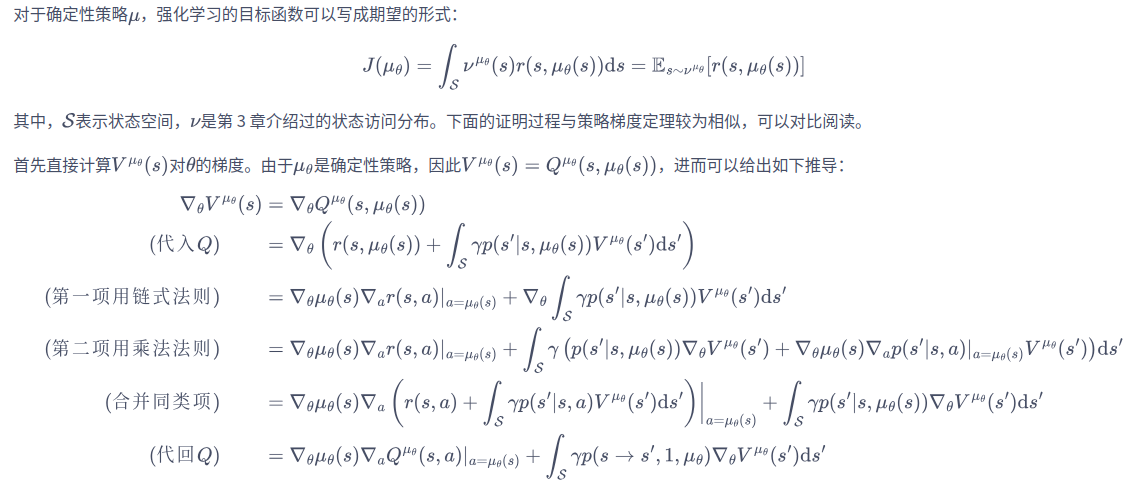  
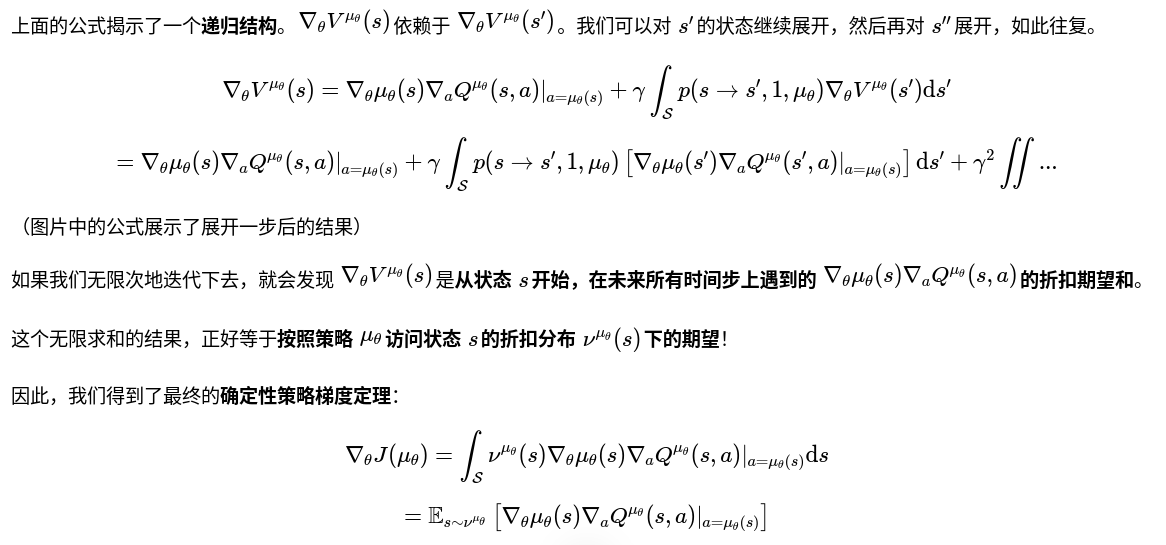

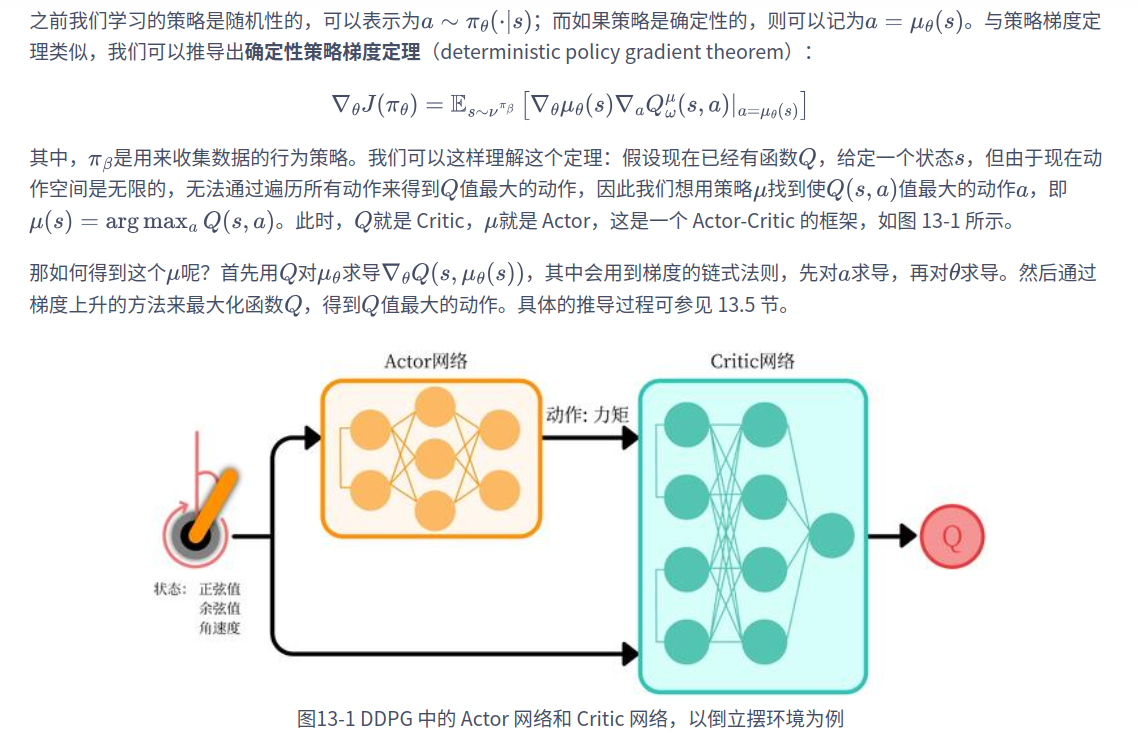  
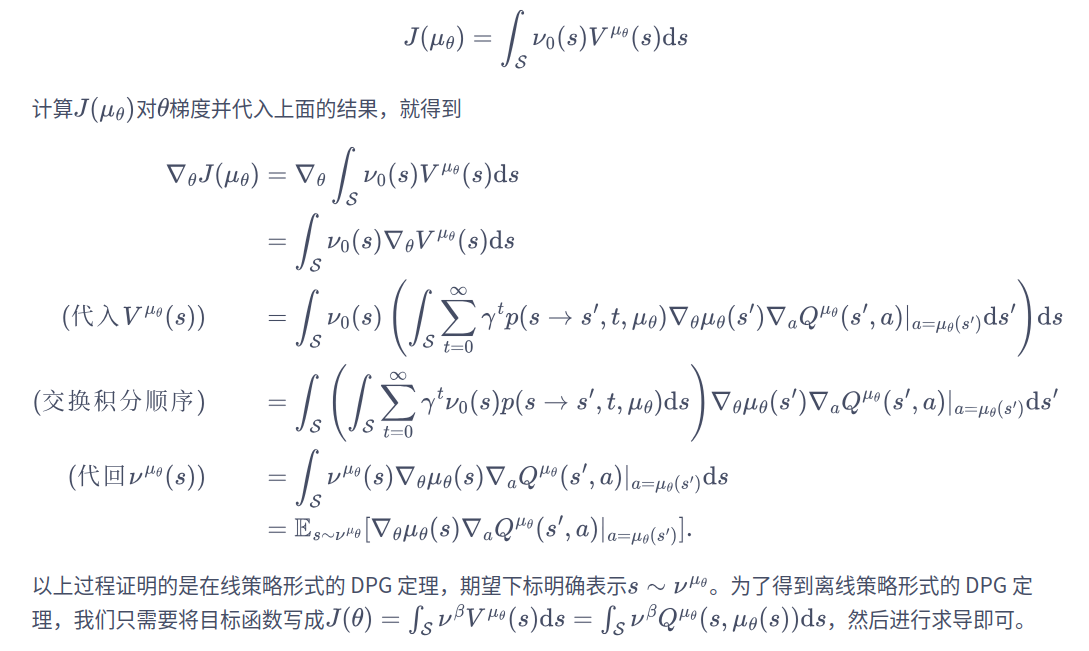

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.tanh(self.fc2(x)) * self.action_bound
        # [-1,1]扩充边界，输出直接就是动作值

class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1) 
        # 拼接状态和动作
        # 输入是状态和动作拼接后的向量
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)
        # 状态动作对的价值

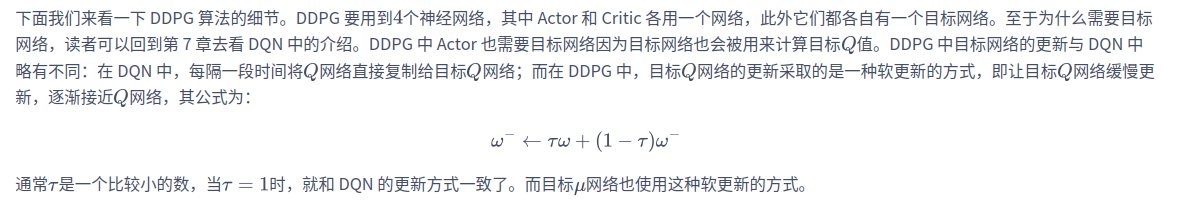  
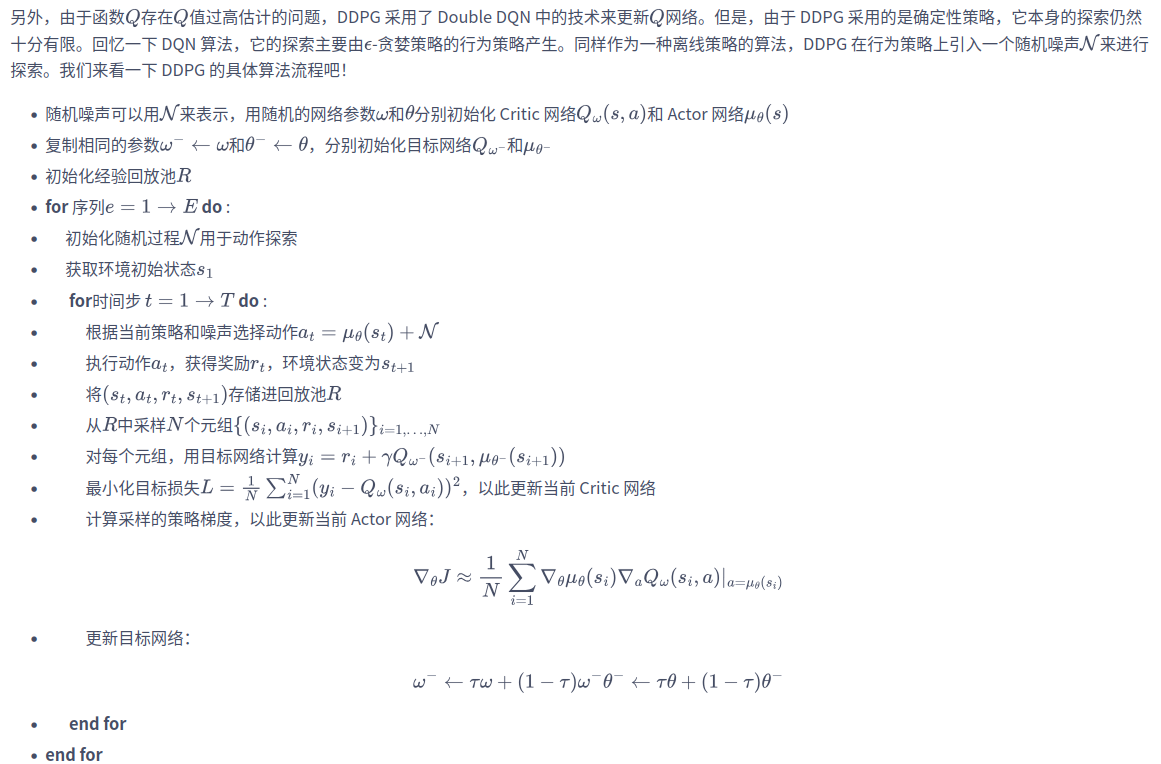

In [3]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 目标网络在几步之后需要进行固定，不需要优化器
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)

        # 初始化目标价值网络并设置和价值网络相同的参数
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并设置和策略相同的参数
        self.target_actor.load_state_dict(self.actor.state_dict())

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_dim = action_dim
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).item()
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(), net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, transition_dict):
        # 输入是以episode为单位的
        # (num_episode_steps,state_dim)
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)

        # (num_episode_steps,1)，这里的动作空间维度是1
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        # q_value直接用目标动作值网络计算，
        next_q_values = self.target_critic(next_states, self.target_actor(next_states))

        # 使用对于被更新的策略网络来说是常量的目标策略和目标值网络来计算TD_target
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        
        critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # 先对q_value网络进行更新，使得q_value网络对当前策略的估计更加准确

        # 使用策略网络输出的动作值作为q_value网络的输入，对一个batch做平均，然后反向传播，求q_value对actor的参数的梯度
        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        # 在当前的q_value估计下，通过优化策略，使得在当前q_value网络下，优化后的策略会使得q_value有所提升，虽然无法达到max(Q(s,a))的效果
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        # actor和critic进行了一次参数更新

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

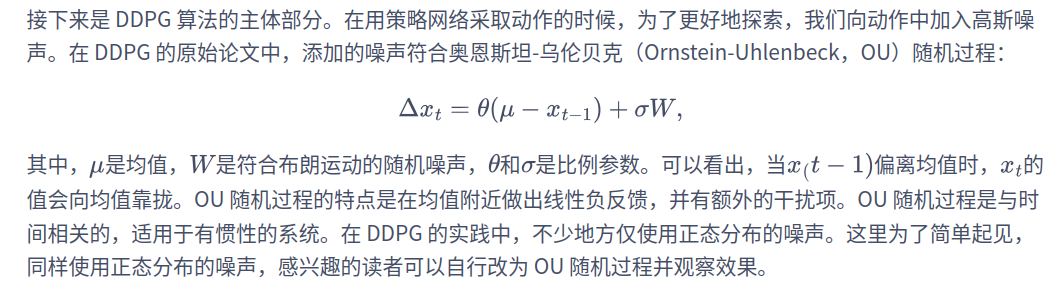

In [6]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 200
hidden_dim = 64
gamma = 0.98
tau = 0.005  # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01  # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, sigma, actor_lr, critic_lr, tau, gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_108806/682582581.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s, episode=200, return=-188.708]


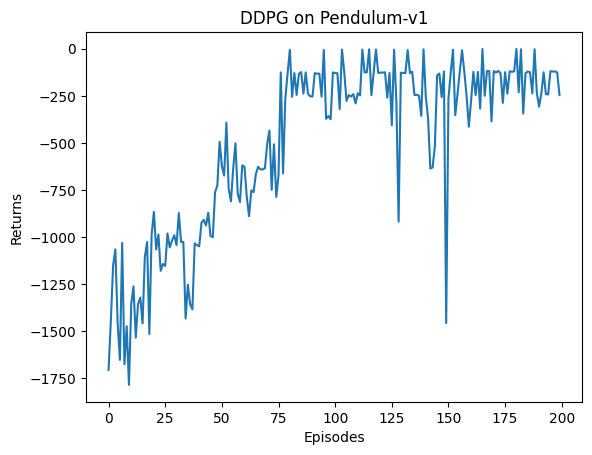

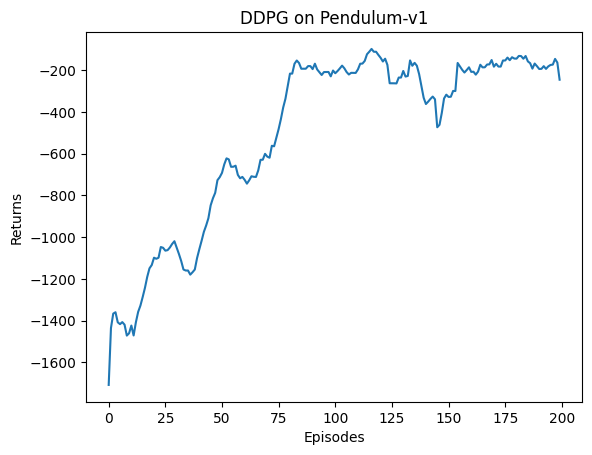

In [7]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()